# Chemical Spectrum Classifier

## Load and preprocess data

### Load dataset

In [0]:
!mkdir data_sample

Load data manually from local storage


In [0]:
%matplotlib inline

import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [0]:
data_path = "/content/data_sample/"
data = pd.DataFrame()


for filename in os.listdir(data_path):
    absorbance = pd.read_csv(data_path + filename)["Absorbance (AU)"]
    absorbance.at[absorbance.size] = filename[:3]
    data = data.append(absorbance, ignore_index=True)
  


Overview of number samples per class

In [0]:
pd.set_option("precision", 3)
data.head(3)

,0,1,2,3,4,5,6,7,8,9,...,219,220,221,222,223,224,225,226,227,228
0,-0.561,-0.554,-0.560,-0.557,-0.550,-0.547,-0.547,-0.543,-0.543,-0.544,...,-0.395,-0.384,-0.374,-0.378,-0.376,-0.364,-0.361,-0.364,-0.362,Gin
1,-0.640,-0.635,-0.637,-0.635,-0.627,-0.622,-0.622,-0.620,-0.620,-0.621,...,-0.514,-0.514,-0.517,-0.517,-0.519,-0.521,-0.521,-0.527,-0.521,Amp
2,-0.179,-0.185,-0.185,-0.181,-0.170,-0.167,-0.166,-0.164,-0.165,-0.167,...,0.223,0.235,0.241,0.243,0.232,0.216,0.254,0.226,0.267,Asc


We will remove classes that have very few samples.

In [0]:
classes = ['Cbs', 'Mel', 'Cel', 'Gua', 'P-S']
data = data[~data[228].isin(classes)]

In [16]:
print(data.shape)

(574, 229)


We will visualize some spectrum of chemical compounds to see their variations. 

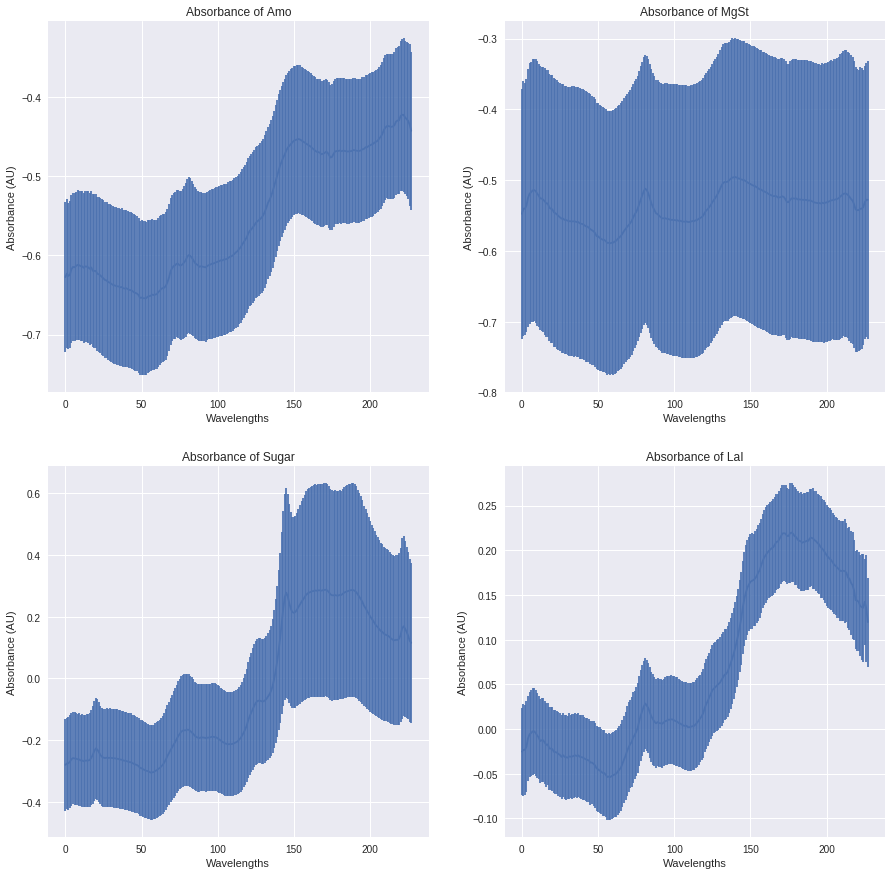

In [0]:
# Spectrum of Amo
fig = plt.figure(figsize=(15, 15))

ax1 = fig.add_subplot(2, 2, 1)
amo = data[data[228] == "Amo"].drop(228, axis=1)
amo.mean().plot(yerr=amo.std(), ax=ax1)
ax1.set(xlabel="Wavelengths", ylabel="Absorbance (AU)", title="Absorbance of Amo")

ax2 = fig.add_subplot(2, 2, 2)
mgs = data[data[228] == "MgS"].drop(228, axis=1)
mgs.mean().plot(yerr=mgs.std(), ax=ax2)
ax2.set(xlabel="Wavelengths", ylabel="Absorbance (AU)", title="Absorbance of MgSt")

ax3 = fig.add_subplot(2, 2, 3)
sug = data[data[228] == "Sug"].drop(228, axis=1)
sug.mean().plot(yerr=sug.std(), ax=ax3)
ax3.set(xlabel="Wavelengths", ylabel="Absorbance (AU)", title="Absorbance of Sugar")

ax4 = fig.add_subplot(2, 2, 4)
lai = data[data[228] == "LaI"].drop(228, axis=1)
lai.mean().plot(yerr=lai.std(), ax=ax4)
ax4.set(xlabel="Wavelengths", ylabel="Absorbance (AU)", title="Absorbance of LaI")

plt.show()

Some of chemical class has high variance data, we already remove outliner before feed data to models.

### Data Preprocessing

In [17]:
data[228].value_counts()

Mag    82
Asc    57
Amp    54
Lac    47
Mep    44
Gel    41
Sug    32
MgS    30
Nac    30
Mal    20
Amo    16
Mac    15
Sta    15
Par    12
MCe    11
Lau    10
Sul    10
SSF    10
Cit    10
LaI    10
Gin     9
Gaf     9
Name: 228, dtype: int64

In [18]:
chemical_code = data[228].unique()
data[228] = data[228].apply(lambda name: np.squeeze(np.where(chemical_code == name)) + 1)
print(chemical_code)

['Asc' 'LaI' 'Mep' 'Nac' 'Lac' 'MCe' 'Sta' 'Gel' 'Cit' 'Sug' 'Gin' 'Amp'
 'MgS' 'Mag' 'Mac' 'Amo' 'Gaf' 'Mal' 'Par' 'SSF' 'Lau' 'Sul']


In [19]:
print("Before dropping NaN rows: ", data.shape)
data = data.dropna()
print("After dropping NaN rows: ", data.shape)

Before dropping NaN rows:  (574, 229)
After dropping NaN rows:  (573, 229)


### Utilities for plotting

In [0]:
def show_prediction_comparison(data, X, index, label, prediction):
    fig = plt.figure(figsize=(15, 5))
    
    ax1 = fig.add_subplot(1, 2, 1)
    sns.lineplot(x=range(228), y=X[index], ax=ax1)
    ax1.set(xlabel="Wavelengths", ylabel="Absorbance (AU)", title="Label {}".format(label) )

    ax2 = fig.add_subplot(1, 2, 2)
    c2 = data[data[228] == prediction].drop(228, axis=1)
    c2.mean().plot(yerr=c2.std(), ax=ax2)
    ax2.set(xlabel="Wavelengths", ylabel="Absorbance (AU)", title="Predict {}".format(prediction))

## Deep Models

### CNN for 1D spectrum with data augmentation to balance data between classes

In [21]:
target = data[228].value_counts()
target = target[target < 40].reset_index()['index'].values # get the classes that have least data points
data_augmented = data.copy()

# simple data augmentation by adding gaussian noise to the mean of each feature of a sample
num_adding = 40
for label in target:
    label_mean = data_augmented[data_augmented[228] == label].drop(228, axis=1).mean().values
    for _ in range(num_adding):
        sample = pd.Series(label_mean)
        sample += np.random.randn(sample.size) * 0.01
        sample.at[sample.size] = label
        data_augmented = data_augmented.append(sample, ignore_index=True)


import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D

from sklearn.model_selection import train_test_split

num_classes = data[228].unique().size
batch_size = 128
epochs = 200

X = data_augmented.drop(228, axis=1).values
Y = data_augmented[228].values


Using TensorFlow backend.


In [28]:
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
cvscores = []
for train, test in kfold.split(X, Y):
  model = Sequential()
  model.add(Dense(64, activation='relu', input_dim=228))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(num_classes, activation='softmax'))
  
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  
  x_train = X[train]
  y_train = keras.utils.to_categorical(Y[train] - 1, num_classes)
  x_test = X[test]
  y_test = keras.utils.to_categorical(Y[test] - 1, num_classes)
  unique, counts = np.unique(Y[train], return_counts=True)
  print("number of classes in train set", np.asarray((unique, counts)).T) 
  unique, counts = np.unique(Y[test], return_counts=True)
  print("number of classes in test set", np.asarray((unique, counts)).T)
  model.fit(x_train, y_train,batch_size=batch_size,epochs=epochs,validation_data=(x_test, y_test))

number of classes in train set [[ 1. 51.]
 [ 2. 45.]
 [ 3. 39.]
 [ 4. 63.]
 [ 5. 42.]
 [ 6. 45.]
 [ 7. 49.]
 [ 8. 36.]
 [ 9. 45.]
 [10. 64.]
 [11. 44.]
 [12. 47.]
 [13. 63.]
 [14. 73.]
 [15. 49.]
 [16. 50.]
 [17. 44.]
 [18. 54.]
 [19. 46.]
 [20. 45.]
 [21. 45.]
 [22. 45.]]
number of classes in test set [[ 1.  6.]
 [ 2.  5.]
 [ 3.  5.]
 [ 4.  7.]
 [ 5.  5.]
 [ 6.  6.]
 [ 7.  6.]
 [ 8.  5.]
 [ 9.  5.]
 [10.  8.]
 [11.  5.]
 [12.  6.]
 [13.  7.]
 [14.  9.]
 [15.  6.]
 [16.  6.]
 [17.  5.]
 [18.  6.]
 [19.  6.]
 [20.  5.]
 [21.  5.]
 [22.  5.]]
Train on 1084 samples, validate on 129 samples
Epoch 1/200
1084/1084 [==============================] - 1s 1ms/step - loss: 3.1000 - acc: 0.0572 - val_loss: 3.0190 - val_acc: 0.1550
Epoch 2/200
1084/1084 [==============================] - 0s 38us/step - loss: 2.9689 - acc: 0.1421 - val_loss: 2.9191 - val_acc: 0.1550
Epoch 3/200
1084/1084 [==============================] - 0s 38us/step - loss: 2.8588 - acc: 0.1522 - val_loss: 2.7995 - val_acc: 0.2558

In [0]:
for index in enumerate(X):
  label = keras.utils.to_categorical(Y[index] - 1, num_classes)
  score = model.evaluate(X[index], label, verbose=0)
  print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))
  cvscores.append(score[1] * 100)

In [29]:
label = keras.utils.to_categorical(Y - 1, num_classes)
score = model.evaluate(X, label, verbose=0)
print(score[1]*100)

98.35119538334708


In [0]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")

In [0]:
print(np.mean(cvscores))

98.51593158970213


In [0]:
def show_predict_label(model, unit):
  result = model.predict(unit)
  return np.argmax(result)

In [0]:
index = 6

unit = X[index].reshape(1,228)
a = show_predict_label(model, unit)
print(chemical_code[a])
print(chemical_code[Y[index]-1])
print(chemical_code)

Lac
Sug
['Gin' 'Amp' 'Asc' 'Gaf' 'Gel' 'Sug' 'Lac' 'SSF' 'Nac' 'Mag' 'Amo' 'Mep'
 'Cit' 'Mal' 'MCe' 'MgS' 'Sul' 'Par' 'Mac' 'Sta' 'Lau' 'LaI']


As can be seen, data augmentation step is very important to improve the performance of CNN classifier. It balanced the sample counts of each classes and hence better capturing pattern of different classes. We will investigate fail cases to see the similarities between absorbance curve.

In [0]:
from keras.models import model_from_json

json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("model.h5")

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


[[57  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 50  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 70  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0 44  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 51  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 55  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 40  0  0  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 50  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  2  0  0  0  0 67  0  1  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 49  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 51  1  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 69  0  1  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0 80  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0

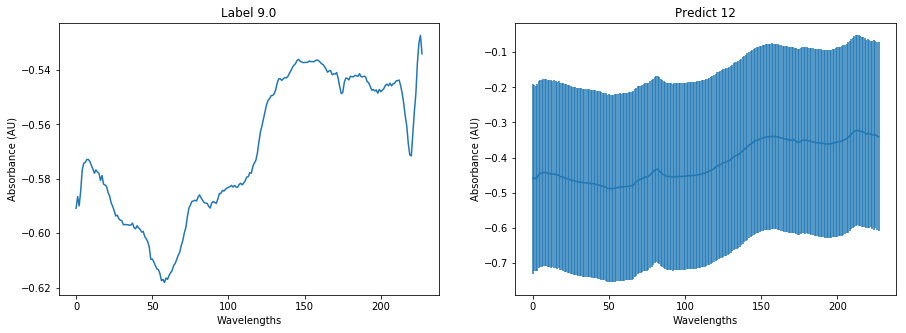

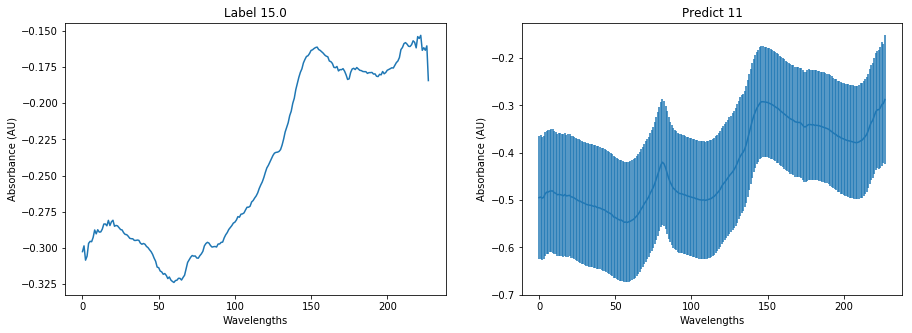

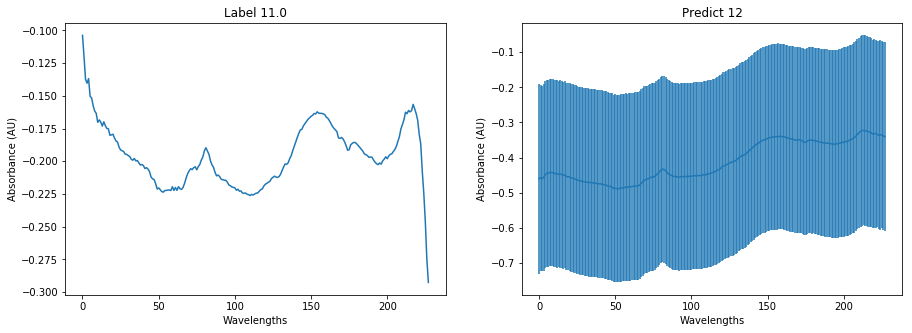

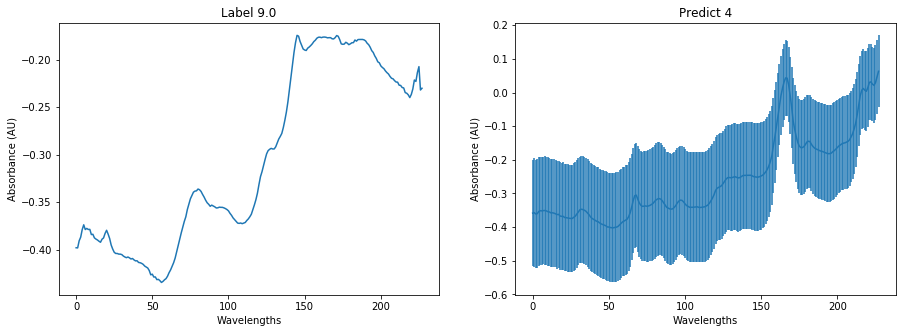

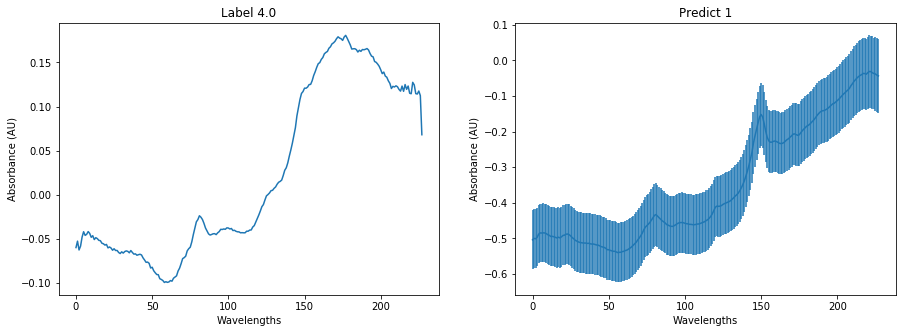

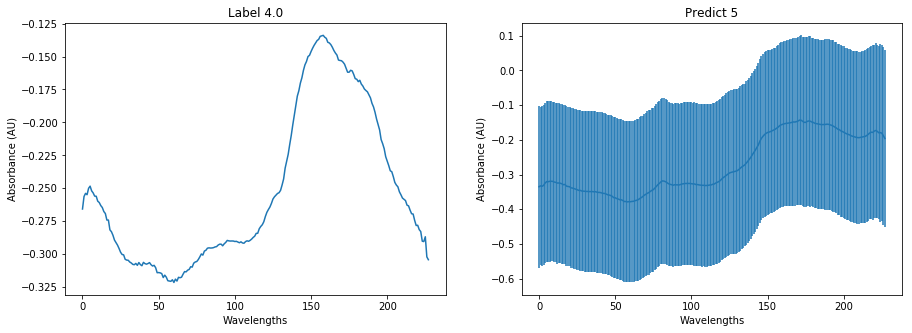

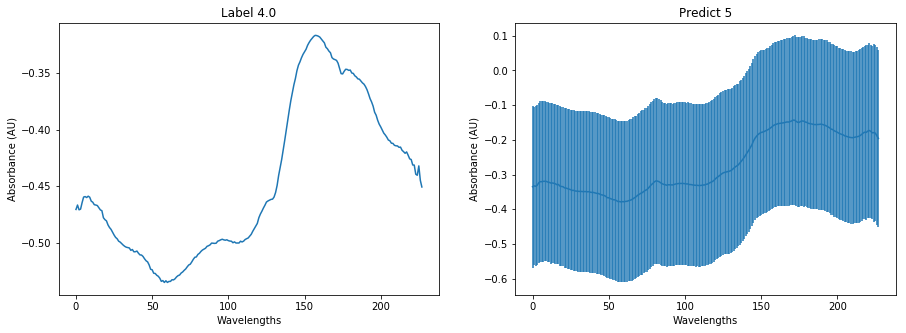

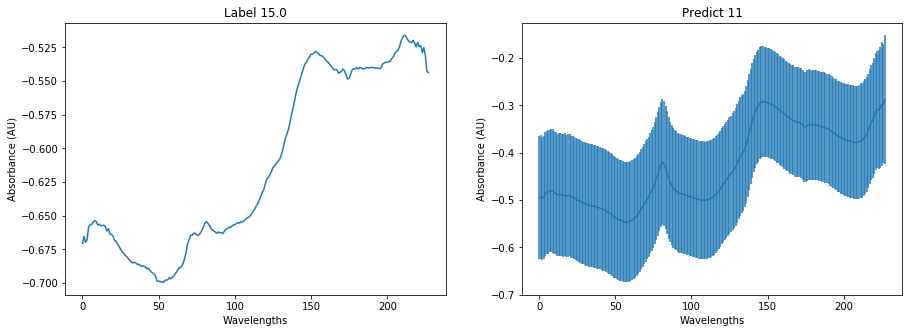

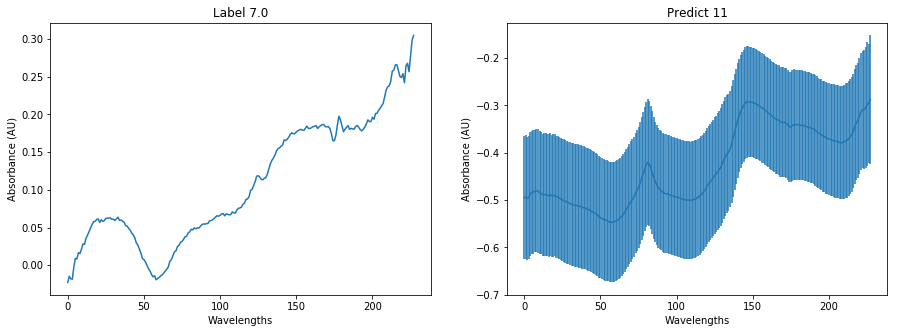

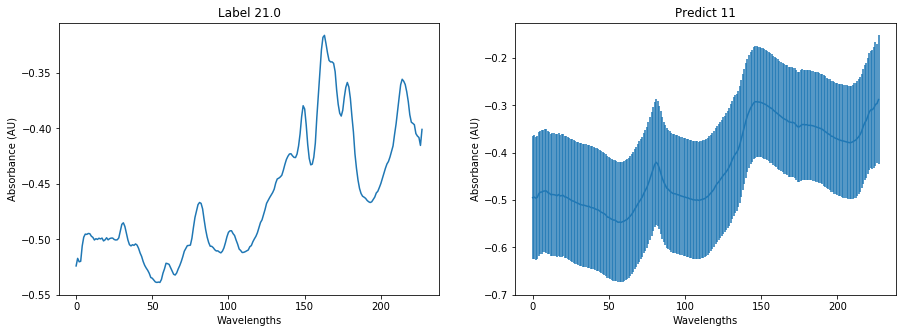

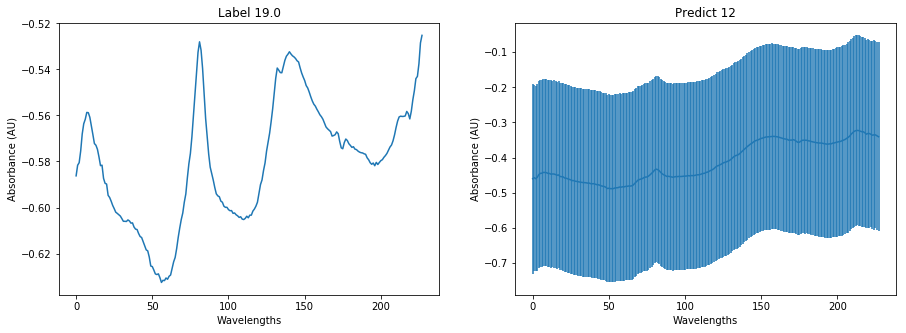

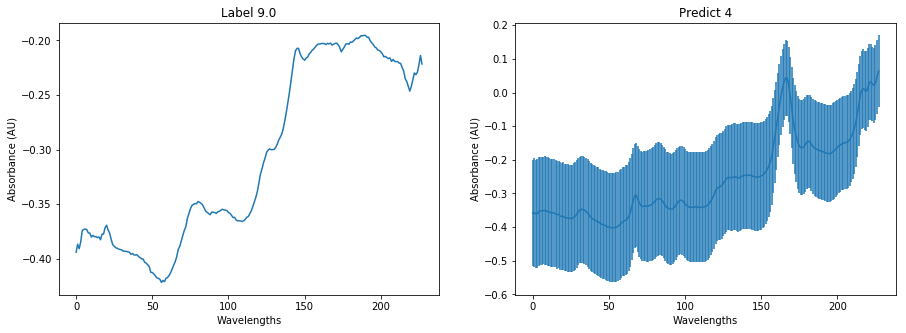

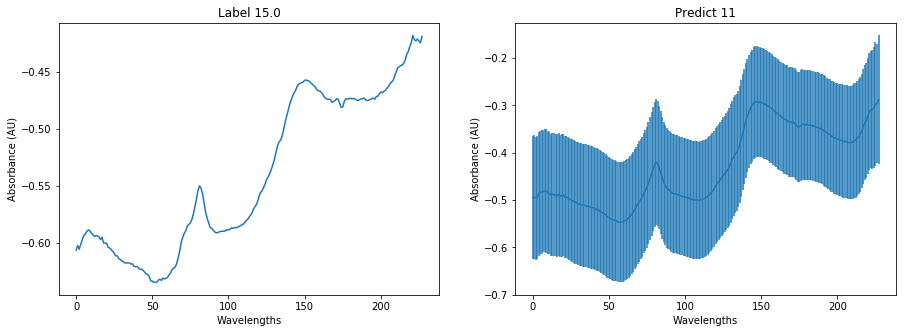

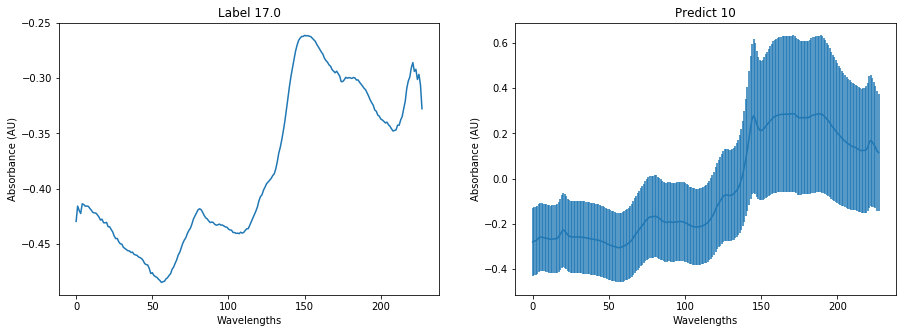

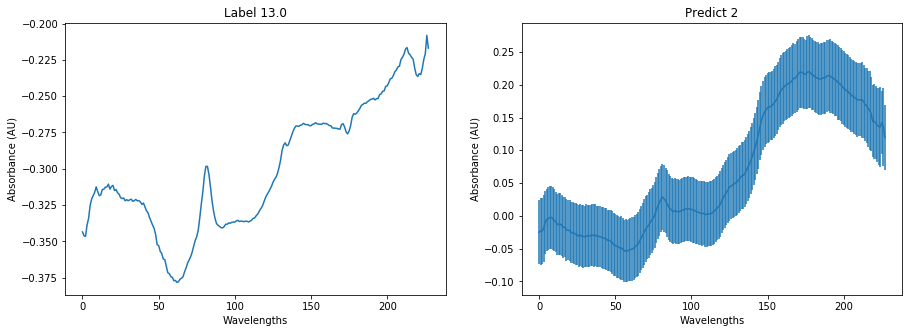

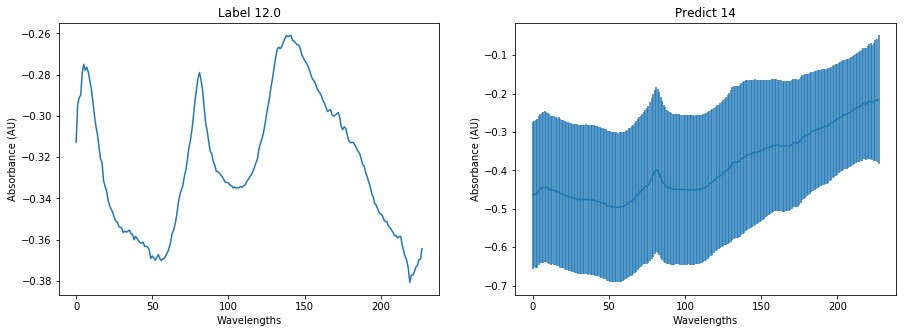

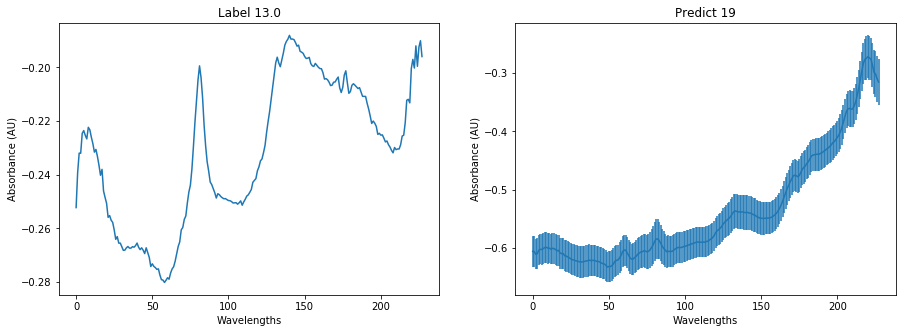

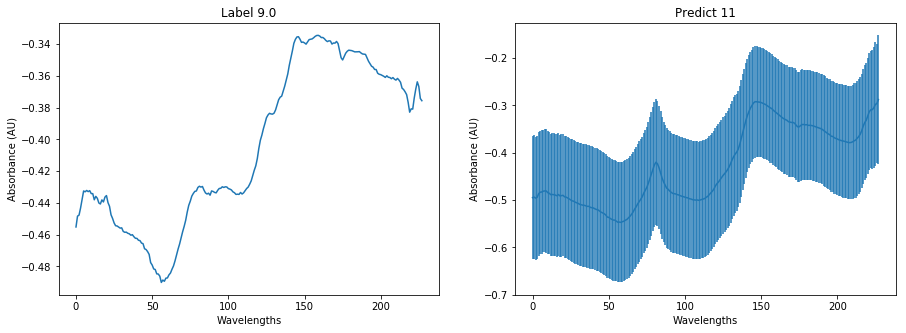

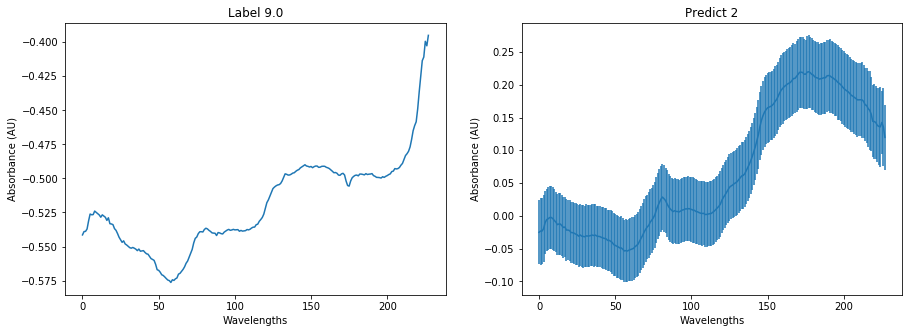

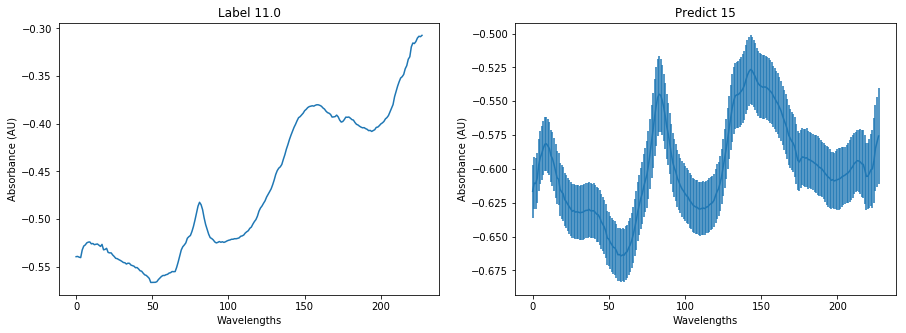

In [38]:
test_predictions = model.predict(X)
test_predictions = np.argmax(test_predictions, axis=1)
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(Y-1, test_predictions)
print(matrix)

incorrects = np.where(test_predictions != Y -1)[0]
print(incorrects)
for index in range(len(incorrects)):
  show_prediction_comparison(data, X, incorrects[index], Y[incorrects[index]] -1, test_predictions[incorrects[index]])

plt.show()